In [17]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from transformers import pipeline, AutoImageProcessor, AutoModelForDepthEstimation
import os
import random
from pathlib import Path
from PIL import Image

In [21]:
to_method = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Randomly sample images from the indoor and outdoor datasets
# Read in sample images
data_root = Path("./data")
data_folder_path = data_root
indoor_folder_path = data_folder_path / "indoor"
outdoor_folder_path = data_folder_path / "outdoor"
num_samples = 3

selected_indoor_images = random.sample(os.listdir(indoor_folder_path), num_samples)
selected_outdoor_images = random.sample(os.listdir(outdoor_folder_path), num_samples)

indoor_images = []
outdoor_images = []

for i in range(num_samples):
    indoor_image = cv2.imread(str(indoor_folder_path / selected_indoor_images[i]))
    indoor_image = cv2.cvtColor(indoor_image, cv2.COLOR_BGR2RGB)
    
    outdoor_image = cv2.imread(str(outdoor_folder_path / selected_outdoor_images[i]))
    outdoor_image = cv2.cvtColor(outdoor_image, cv2.COLOR_BGR2RGB)
    
    indoor_images.append(indoor_image)
    outdoor_images.append(outdoor_image)

# Check that shapes are reasonable
print(indoor_images[0].shape, outdoor_images[0].shape)

(167, 241, 3) (600, 407, 3)


In [22]:
model_id = "depth-anything/Depth-Anything-V2-Large-hf"

# Use AutoProcessor (not AutoImageProcessor!)
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id).to(to_method)

print(model.config)

DepthAnythingConfig {
  "architectures": [
    "DepthAnythingForDepthEstimation"
  ],
  "backbone": null,
  "backbone_config": {
    "apply_layernorm": true,
    "architectures": [
      "Dinov2Model"
    ],
    "attention_probs_dropout_prob": 0.0,
    "drop_path_rate": 0.0,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 1024,
    "image_size": 518,
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-06,
    "layerscale_value": 1.0,
    "mlp_ratio": 4,
    "model_type": "dinov2",
    "num_attention_heads": 16,
    "num_channels": 3,
    "num_hidden_layers": 24,
    "out_features": [
      "stage5",
      "stage12",
      "stage18",
      "stage24"
    ],
    "out_indices": [
      5,
      12,
      18,
      24
    ],
    "patch_size": 14,
    "qkv_bias": true,
    "reshape_hidden_states": false,
    "stage_names": [
      "stem",
      "stage1",
      "stage2",
      "stage3",
      "stage4",
      "stage5",
      "stage6",
      "stage7",
      "sta

In [23]:
indoor_samples = []
outdoor_samples = []

for i in range(num_samples):
    # Preprocess indoor and outdoor images
    indoor_input = processor(images=indoor_images[i], return_tensors="pt").to(to_method)
    outdoor_input = processor(images=outdoor_images[i], return_tensors="pt").to(to_method)

    # Inference
    with torch.no_grad():
        indoor_outputs = model(**indoor_input)
        outdoor_outputs = model(**outdoor_input)

    # Extract and process predicted depth
    indoor_depth = indoor_outputs.predicted_depth.squeeze().cpu().numpy()
    outdoor_depth = outdoor_outputs.predicted_depth.squeeze().cpu().numpy()

    # Append image and depth pairs to samples list
    indoor_samples.append([indoor_images[i], indoor_depth])
    outdoor_samples.append([outdoor_images[i], outdoor_depth])

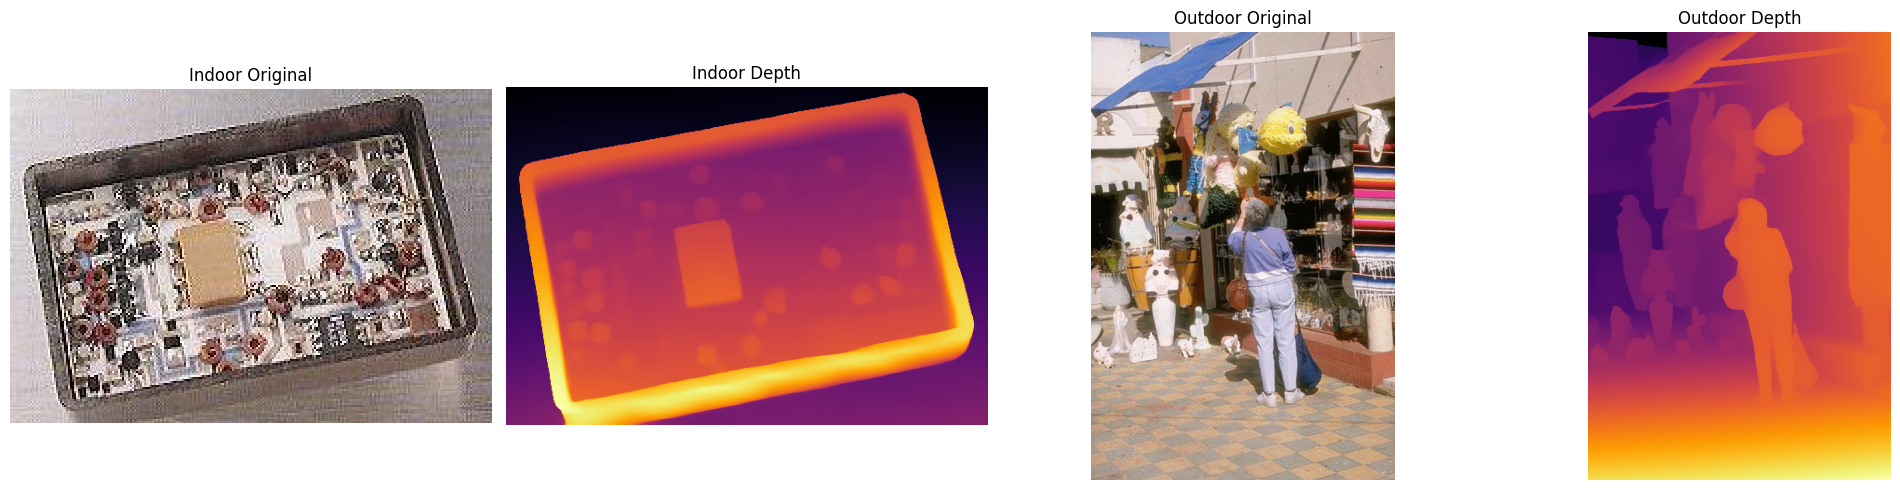

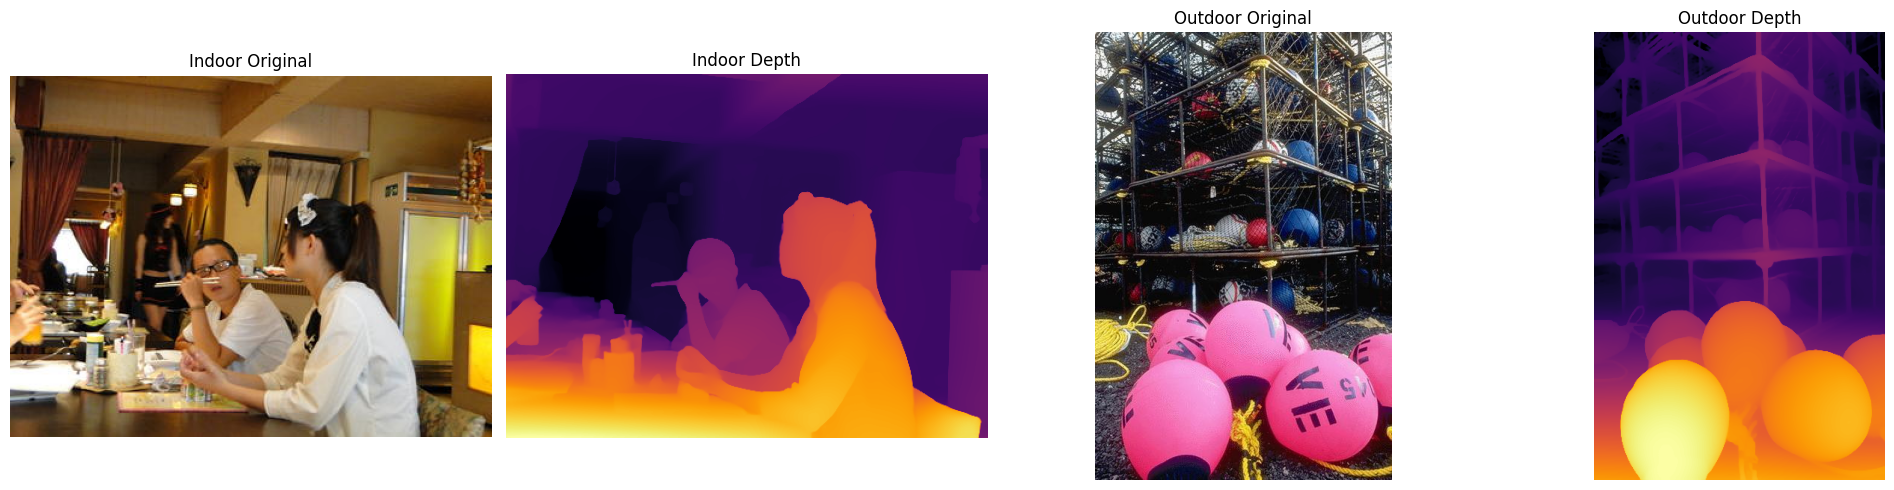

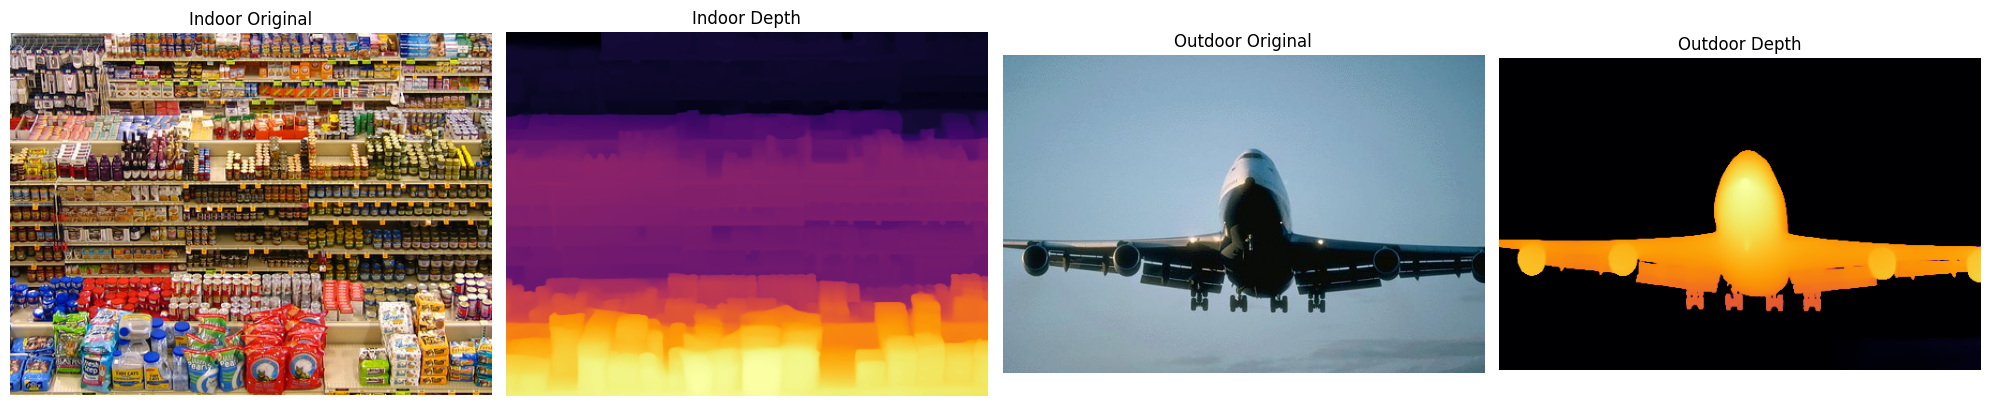

In [24]:
for i in range(num_samples):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    axs[0].imshow(indoor_samples[i][0])
    axs[0].set_title('Indoor Original')
    axs[0].axis('off')
    
    axs[1].imshow(indoor_samples[i][1], cmap='inferno')
    axs[1].set_title('Indoor Depth')
    axs[1].axis('off')
    
    axs[2].imshow(outdoor_samples[i][0])
    axs[2].set_title('Outdoor Original')
    axs[2].axis('off')
    
    axs[3].imshow(outdoor_samples[i][1], cmap='inferno')
    axs[3].set_title('Outdoor Depth')
    axs[3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [25]:
def get_intrinsics(H, W, fov=55.0):
    """
    Intrinsics for a pinhole camera model.
    Assume fov (field of view) in degrees and central principal point.

    Parameters:
    - H: image height (pixels)
    - W: image width (pixels)
    - fov: horizontal field of view in degrees (default 55)

    Returns:
    - 3x3 camera intrinsics matrix K
    """
    f = 0.5 * W / np.tan(0.5 * fov * np.pi / 180.0)  # focal length in pixels
    cx = 0.5 * W  # principal point x-coordinate (center)
    cy = 0.5 * H  # principal point y-coordinate (center)

    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0, 1]
    ])
    return K


In [26]:
def pixel_to_point(depth_image, camera_intrinsics=None, fov=55.0):
    """
    Convert depth image to 3D points (x, y, z) in camera coordinates.

    Parameters:
    - depth_image: 2D numpy array of depth values
    - camera_intrinsics: 3x3 numpy array (optional). If None, computed from fov.
    - fov: field of view in degrees (used if camera_intrinsics is None)

    Returns:
    - x, y, z: 2D arrays representing 3D coordinates of each pixel
    """
    height, width = depth_image.shape

    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width, fov=fov)

    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]

    # Create pixel coordinate grid
    x_coords = np.linspace(0, width - 1, width)
    y_coords = np.linspace(0, height - 1, height)
    u, v = np.meshgrid(x_coords, y_coords)

    # Compute normalized pixel coordinates relative to principal point
    x_over_z = (u - cx) / fx
    y_over_z = (v - cy) / fy

    # Compute z (depth adjusted for angle)
    z = depth_image / np.sqrt(1.0 + x_over_z**2 + y_over_z**2)

    # Compute actual x and y coordinates
    x = x_over_z * z
    y = y_over_z * z

    return x, y, z

In [27]:
def create_point_cloud(depth_image, color_image, camera_intrinsics=None, scale_ratio=100.0):
    """
    Create a colored point cloud from a depth image and corresponding color image.

    Parameters:
    - depth_image: 2D numpy array (depth map)
    - color_image: 3D numpy array (color image)
    - camera_intrinsics: 3x3 numpy array (camera matrix). If None, computed from fov=55
    - scale_ratio: float, scale factor to convert depth units to meters (or desired scale)

    Returns:
    - open3d.geometry.PointCloud object with points and colors
    """
    height, width = depth_image.shape

    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width, fov=55.0)

    # Resize color image to match depth image size if needed
    color_image = cv2.resize(color_image, (width, height))

    # Avoid zeros in depth image to prevent division errors
    depth_image = np.maximum(depth_image, 1e-5)

    # Convert depth scale (depending on how depth is represented)
    depth_scaled = scale_ratio / depth_image

    # Compute 3D points from depth
    x, y, z = pixel_to_point(depth_scaled, camera_intrinsics)

    # Stack into (H, W, 3) array of XYZ points
    point_image = np.stack((x, y, z), axis=-1)

    # Create Open3D point cloud
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(point_image.reshape(-1, 3))
    cloud.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)

    # Optional: Mask out points with very large depth (e.g., sky)
    # mask = point_image[:, :, 2] < 1e3
    # cloud.points = o3d.utility.Vector3dVector(point_image[mask].reshape(-1, 3))
    # cloud.colors = o3d.utility.Vector3dVector(color_image[mask].reshape(-1, 3) / 255.0)

    return cloud

In [28]:
output_path = data_root / "point_clouds"
os.makedirs(output_path, exist_ok=True)

for i in range(num_samples):
    # Create point cloud for indoor sample
    cloud = create_point_cloud(indoor_samples[i][1], indoor_samples[i][0])
    o3d.io.write_point_cloud(output_path / f"indoor_point_cloud_{i}.ply", cloud)

    # Create point cloud for outdoor sample
    cloud = create_point_cloud(outdoor_samples[i][1], outdoor_samples[i][0])
    o3d.io.write_point_cloud(output_path / f"outdoor_point_cloud_{i}.ply", cloud)